<a href="https://colab.research.google.com/github/SripathiShivani/mcd_ml/blob/main/mcd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
DATASET_ZIP = '/content/drive/MyDrive/Malaria/Malaria.zip'  # Path to the dataset ZIP file in Google Drive
EXTRACT_PATH = '/content/cell_images'  # Extracted dataset location
BASE_DIR = '/content/malaria_dataset'

# Create necessary directories for training and validation
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')

CLASS_NAMES = ['Parasitized', 'Uninfected']
for split in [TRAIN_DIR, VALIDATION_DIR]:
    for cls in CLASS_NAMES:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

# Unzip the dataset
import zipfile
if not os.path.exists(EXTRACT_PATH):
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall('/content')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from sklearn.model_selection import train_test_split
import shutil

# Split the dataset into training and validation sets
def split_data():
    for cls in CLASS_NAMES:
        cls_path = os.path.join(EXTRACT_PATH, cls)
        images = os.listdir(cls_path)

        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(TRAIN_DIR, cls, img))
        for img in val_images:
            shutil.copy(os.path.join(cls_path, img), os.path.join(VALIDATION_DIR, cls, img))

split_data()


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Hyperparameters
IMG_SIZE = (224, 224)  # Input size for VGG19
BATCH_SIZE = 32

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
)


Found 22046 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the VGG19 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Display the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=10,
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,235,905 (88.64 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


688/688 ━━━━━━━━━━━━━━━━━━━━ 346s 476ms/step - accuracy: 0.6735 - loss: 0.6049 - val_accuracy: 0.8508 - val_loss: 0.3823
Epoch 2/10
  1/688 ━━━━━━━━━━━━━━━━━━━━ 1:36 141ms/step - accuracy: 0.7188 - loss: 0.4893

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


688/688 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7188 - loss: 0.4893 - val_accuracy: 1.0000 - val_loss: 0.3168
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 318s 459ms/step - accuracy: 0.8085 - loss: 0.4338 - val_accuracy: 0.8726 - val_loss: 0.3356
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - accuracy: 0.7812 - loss: 0.5366 - val_accuracy: 0.8750 - val_loss: 0.1973
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 317s 458ms/step - accuracy: 0.8319 - loss: 0.3861 - val_accuracy: 0.8805 - val_loss: 0.3079
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 109us/step - accuracy: 0.8438 - loss: 0.4876 - val_accuracy: 0.7500 - val_loss: 0.3224
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 322s 457ms/step - accuracy: 0.8442 - loss: 0.3682 - val_accuracy: 0.8183 - val_loss: 0.3727
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 113us/step - accuracy: 0.9375 - loss: 0.2885 - val_accuracy: 0.7500 - val_loss: 0.4189
Epoch 9/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 317s 457ms/step - accuracy: 0.8504 - loss: 0.3585 - val_a

In [ ]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=5,
)


Epoch 1/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 338s 478ms/step - accuracy: 0.8881 - loss: 0.2966 - val_accuracy: 0.9331 - val_loss: 0.1809
Epoch 2/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - accuracy: 0.8438 - loss: 0.2784 - val_accuracy: 1.0000 - val_loss: 0.0408
Epoch 3/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 330s 476ms/step - accuracy: 0.9173 - loss: 0.2332 - val_accuracy: 0.9497 - val_loss: 0.1553
Epoch 4/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9688 - loss: 0.1339 - val_accuracy: 1.0000 - val_loss: 0.0908
Epoch 5/5
688/688 ━━━━━━━━━━━━━━━━━━━━ 331s 475ms/step - accuracy: 0.9221 - loss: 0.2179 - val_accuracy: 0.9535 - val_loss: 0.1512


173/173 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.9531 - loss: 0.1661
Validation Accuracy: 95.34%


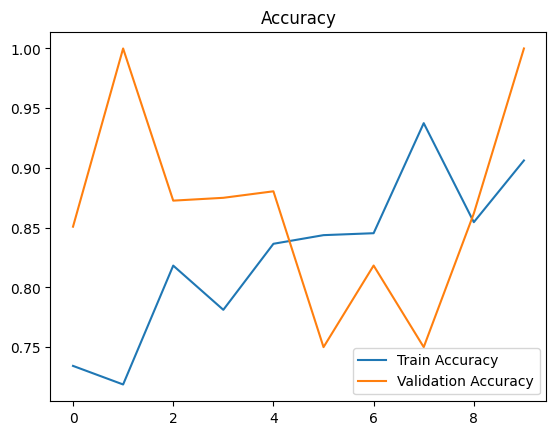

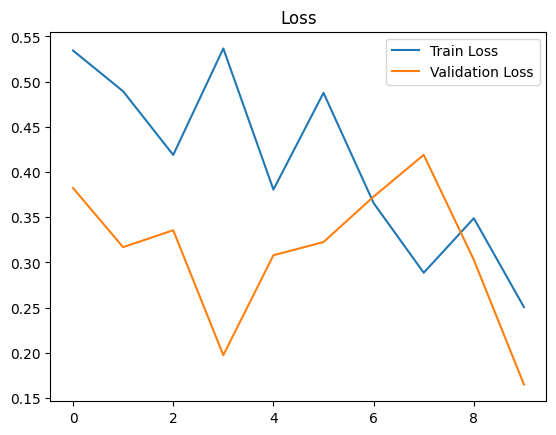

In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/Malaria/malaria_vgg19_model.h5')

# Evaluate the model
evaluation = model.evaluate(validation_generator)
print(f"Validation Accuracy: {evaluation[1] * 100:.2f}%")

# Visualize results
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = load_model('/content/drive/MyDrive/Malaria/malaria_vgg19_model.h5')  # Update with your model path

# Function to preprocess the image for inference
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image with the specified target size
    img = load_img(image_path, target_size=target_size)
    # Convert the image to an array
    img_array = img_to_array(img)
    # Rescale pixel values to [0, 1]
    img_array = img_array / 255.0
    # Add a batch dimension (as required by the model)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to make predictions
def predict_image(model, image_path, class_indices):
    # Preprocess the image
    preprocessed_image = preprocess_image(image_path)
    # Predict the class probabilities
    predictions = model.predict(preprocessed_image)
    # Since it's binary classification, prediction will be a single probability value
    predicted_class = 1 if predictions[0] >= 0.5 else 0
    # Map the class index back to the class label
    label_map = {v: k for k, v in class_indices.items()}
    predicted_label = label_map[predicted_class]
    return predicted_label

# Path to the image to predict
image_path = '/content/drive/MyDrive/Dataset/Test/Uninfected/C3thin_original_IMG_20150608_163002_cell_159.png'  # Replace with your image path

# Use the class indices from the training set
class_indices = {'Parasitized': 0, 'Uninfected': 1}  # Update this if you saved `training_set.class_indices`

# Predict the class of the image
predicted_label = predict_image(model, image_path, class_indices)

# Output the prediction
print(f'The predicted class for the image is: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The predicted class for the image is: Uninfected
